In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb

In [4]:
np.random.seed(42)

In [10]:
# Create synthetic dataset to simulate solar power and environmental data
# Generating data ranges for last year
dates = pd.date_range(start = "2024-01-01", end = "2024-12-31", freq = "h")
n_samples = len(dates)

In [12]:
# Creating base Dataframe with timestamps
df = pd.DataFrame({'timestamp': dates})

In [14]:
# Add hour of day and day of year features
df['hour'] = df['timestamp'].dt.hour
df['day_of_year'] = df['timestamp'].dt.dayofyear
df['month'] = df['timestamp'].dt.month

In [20]:
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

In [22]:
df['day_sin'] = np.sin(2 * np.pi * df['day_of_year'] / 365)
df['day_cos'] = np.cos(2 * np.pi * df['day_of_year'] / 365)

In [24]:
temp_base = 15 + 10 * np.sin(2 * np.pi * df['day_of_year'] / 365)  # Seasonal time pattern
temp_daily = 5 * np.sin(2 * np.pi * df['hour'] / 24)  # Daily time pattern
df['temperature'] = temp_base + temp_daily + np.random.normal(0, 2, n_samples) # Noise data

In [146]:
# Cloud cover
cloud_base = 40 + 20 * np.sin(2 * np.pi * (df['day_of_year'] - 30) / 365)  # Seasonal pattern
cloud_daily = 10 * np.sin(2 * np.pi * (df['hour'] - 6) / 24)  # Daily pattern
df['cloud_cover'] = np.clip(cloud_base + cloud_daily + np.random.normal(0, 15, n_samples), 0, 100)  # Add noise

In [148]:
# Irradiance - affected by time of day, season, and cloud cover
# Base irradiance pattern throughout the day (bell curve)
hour_factor = np.exp(-0.5 * ((df['hour'] - 12) / 5) ** 2) * 1000
# Seasonal variation 
season_factor = 0.5 + 0.5 * np.sin(2 * np.pi * (df['day_of_year'] - 172)/365)
# Cloud cover effect
cloud_factor = 1 - (df['cloud_cover'] / 100) * 0.8
df['irradiance'] = hour_factor * season_factor * cloud_factor
df.loc[(df['hour'] < 6) | (df['hour'] > 20), 'irradiance'] = 0

In [150]:
# Generate dust concentration data - with seasonal patterns and random events
dust_seasonal = 20 + 15 * np.sin(2 * np.pi * (df['day_of_year'] - 150) / 365)
# Random events
dust_events = np.zeros(n_samples)

In [152]:
for _ in range(20): #Considering 20 dust events per year
    event_start = np.random.randint(0, n_samples - 72)  # Random start time
    event_duration = np.random.randint(12, 72)  # Duration between 12 and 72 hours
    event_intensity = np.random.uniform(50, 150)  # Intensity between 50 and 150 irradiance
    
    # Bull curve - for the seasonsal time patterns
    for i in range(event_duration):
        position = event_start + i
        if position < n_samples:
            dust_events[position] = event_intensity * np.exp(-0.5 * ((i - event_duration / 2) / (event_duration / 4)) ** 2)

In [154]:
df['dust_concentration'] = dust_seasonal + dust_events + np.random.normal(0, 5, n_samples)
df['dust_concentration'] = np.clip(df['dust_concentration'], 0, None) #No negative dust values for this consideration

In [156]:
# Generate synthetic solar power output (kW) for a 5 MW plant
max_capacity = 5000  # 5 MW
base_output = df['irradiance'] / 1000 * max_capacity  # Converting irradiance to capacity factor
temp_effect = 1 - 0.004 * np.clip(df['temperature'] - 25, 0, None)  # 0.4% decrease per degree above 25°C

In [158]:
rain_events = np.random.rand(n_samples) < 0.05
accumulated_dust = np.zeros(n_samples)
current_dust = 0

In [160]:
for i in range(n_samples):
    if df['irradiance'][i] > 0:
        # Accumulation rate - current dust concentration
        current_dust += df['dust_concentration'][i] * 0.0001
    if rain_events[i]:
        current_dust *= 0.2  # 80% of dust cleared (20%)
    accumulated_dust[i] = current_dust

In [162]:
max_acc_dust = np.percentile(accumulated_dust, 95)  # Use 95th percentile to avoid outliers
dust_factor = 1 - 0.30 * (accumulated_dust / max_acc_dust)  # Upto 30% reduction due to dust

In [164]:
df['solar_power'] = base_output * temp_effect * dust_factor
df['solar_power'] = df['solar_power'] + np.random.normal(0, 0.05 * max_capacity, n_samples)
df['solar_power'] = np.clip(df['solar_power'], 0, max_capacity) 
df.loc[df['irradiance'] == 0, 'solar_power'] = 0

In [166]:
# Data Analysis

In [168]:
# Set figure aesthetics
plt.figure(figsize = (14, 8))
sns.set_style('whitegrid')

<Figure size 1400x800 with 0 Axes>

Text(0.5, 1.0, 'Solar Power vs Irradiance')

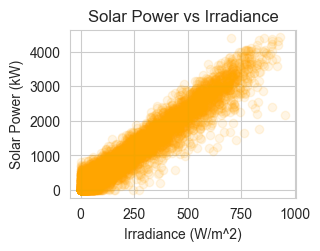

In [170]:
plt.subplot(2, 2, 1)
plt.scatter(df['irradiance'], df['solar_power'], alpha = 0.1, color = 'orange')
plt.xlabel('Irradiance (W/m^2)')
plt.ylabel('Solar Power (kW)')
plt.title('Solar Power vs Irradiance')

Text(0.5, 1.0, 'Solar Power vs Temperature')

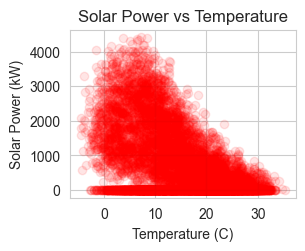

In [172]:
plt.subplot(2, 2, 2)
plt.scatter(df['temperature'], df['solar_power'], alpha = 0.1, color = 'red')
plt.xlabel('Temperature (C)')
plt.ylabel('Solar Power (kW)')
plt.title('Solar Power vs Temperature')

Text(0.5, 1.0, 'Solar Power vs Cloud Cover')

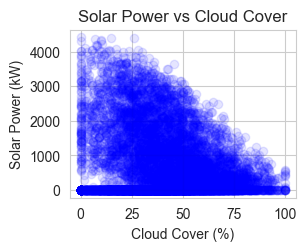

In [174]:
plt.subplot(2, 2, 3)
plt.scatter(df['cloud_cover'], df['solar_power'], alpha = 0.1, color = 'blue')
plt.xlabel('Cloud Cover (%)')
plt.ylabel('Solar Power (kW)')
plt.title('Solar Power vs Cloud Cover')

Text(0.5, 1.0, 'Solar Power vs Dust Concentration')

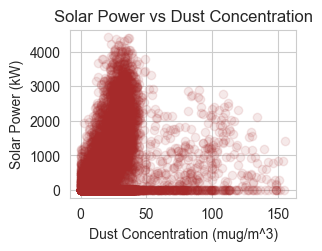

In [176]:
plt.subplot(2, 2, 4)
plt.scatter(df['dust_concentration'], df['solar_power'], alpha = 0.1, color = 'brown')
plt.xlabel('Dust Concentration (mug/m^3)')
plt.ylabel('Solar Power (kW)')
plt.title('Solar Power vs Dust Concentration')

In [178]:
plt.tight_layout()

<Figure size 640x480 with 0 Axes>

In [180]:
sample_period = df[(df['timestamp'] >= '2024-05-01') & (df['timestamp'] <= '2024-05-15')]

In [182]:
plt.figure(figsize = (14, 10))

<Figure size 1400x1000 with 0 Axes>

<Figure size 1400x1000 with 0 Axes>

([], [])

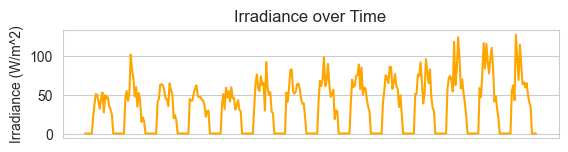

In [184]:
plt.subplot(3, 1, 1)
plt.plot(sample_period['timestamp'], sample_period['irradiance'], color = 'orange')
plt.title('Irradiance over Time')
plt.ylabel('Irradiance (W/m^2)')
plt.xticks([])

([], [])

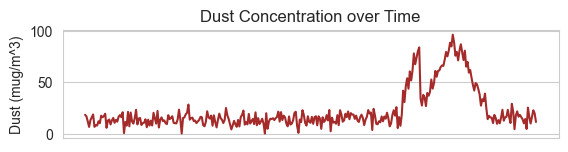

In [186]:
plt.subplot(3, 1, 2)
plt.plot(sample_period['timestamp'], sample_period['dust_concentration'], color='brown')
plt.title('Dust Concentration over Time')
plt.ylabel('Dust (mug/m^3)')
plt.xticks([])

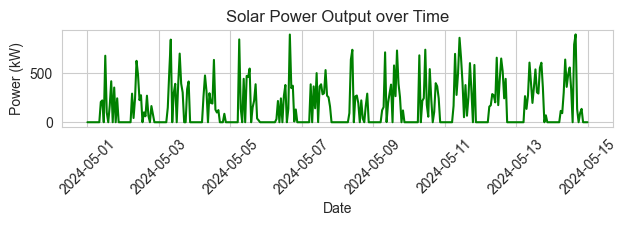

In [188]:
plt.subplot(3, 1, 3)
plt.plot(sample_period['timestamp'], sample_period['solar_power'], color = 'green')
plt.title('Solar Power Output over Time')
plt.ylabel('Power (kW)')
plt.xlabel('Date')
plt.xticks(rotation = 45)
plt.tight_layout()

In [72]:
# Model Training and Evaluation

In [190]:
# Keep only daytime hours for modeling (when solar power > 0)
df_day = df[df['irradiance'] > 0].copy()
features_baseline = ['hour_sin', 'hour_cos', 'day_sin', 'day_cos', 
                    'temperature', 'cloud_cover', 'irradiance']
features_enhanced = features_baseline + ['dust_concentration']
# Our target variable would be solar
target = 'solar_power'

In [192]:
# Split data into training and testing sets
X_baseline = df_day[features_baseline]
X_enhanced = df_day[features_enhanced]
y = df_day[target]

X_train_baseline, X_test_baseline, y_train, y_test = train_test_split(X_baseline, y, test_size = 0.2, random_state = 42)
X_train_enhanced, X_test_enhanced, _, _ = train_test_split(X_enhanced, y, test_size = 0.2, random_state = 42)

In [194]:
scaler_baseline = StandardScaler()
scaler_enhanced = StandardScaler()

In [196]:
X_train_baseline_scaled = scaler_baseline.fit_transform(X_train_baseline)
X_test_baseline_scaled = scaler_baseline.transform(X_test_baseline)

In [198]:
X_train_enhanced_scaled = scaler_enhanced.fit_transform(X_train_enhanced)
X_test_enhanced_scaled = scaler_enhanced.transform(X_test_enhanced)

In [202]:
# GBM
baseline_model = GradientBoostingRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5,
    random_state = 42,
    loss = 'squared_error'
)

In [204]:
baseline_model.fit(X_train_baseline_scaled, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [206]:
# Enhanced - With dust features
enhanced_model = GradientBoostingRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5,
    random_state = 42,
    loss = 'squared_error'
)

In [208]:
enhanced_model.fit(X_train_enhanced_scaled, y_train)

GradientBoostingRegressor(max_depth=5, random_state=42)

In [210]:
# XGBoost model
baseline_xgb = xgb.XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5,
    random_state = 42
)
enhanced_xgb = xgb.XGBRegressor(
    n_estimators = 100,
    learning_rate = 0.1,
    max_depth = 5,
    random_state = 42
)

In [212]:
baseline_xgb.fit(X_train_baseline_scaled, y_train)
enhanced_xgb.fit(X_train_enhanced_scaled, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [116]:
# Make predictions
y_pred_baseline = baseline_model.predict(X_test_baseline_scaled)
y_pred_enhanced = enhanced_model.predict(X_test_enhanced_scaled)

In [118]:
y_pred_baseline_xgb = baseline_xgb.predict(X_test_baseline_scaled)
y_pred_enhanced_xgb = enhanced_xgb.predict(X_test_enhanced_scaled)

In [214]:
# Evaluating models
def evaluate_model(y_true, y_pred, model_name):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    r2 = r2_score(y_true, y_pred)
    return {
        'Model': model_name,
        'MAE': mae,
        'RMSE': rmse,
        'R^2': r2
    }

In [216]:
results = []
results.append(evaluate_model(y_test, y_pred_baseline, 'Baseline GBM'))
results.append(evaluate_model(y_test, y_pred_enhanced, 'Enhanced GBM (with Dust)'))
results.append(evaluate_model(y_test, y_pred_baseline_xgb, 'Baseline XGBoost'))
results.append(evaluate_model(y_test, y_pred_enhanced_xgb, 'Enhanced XGBoost (with Dust)'))

In [218]:
# Display results
results_df = pd.DataFrame(results)
print("Model Performance Comparison:")
print(results_df)

Model Performance Comparison:
                          Model         MAE        RMSE       R^2
0                  Baseline GBM  321.122354  442.469045  0.799858
1      Enhanced GBM (with Dust)  323.541207  447.822695  0.794985
2              Baseline XGBoost  322.651105  444.011220  0.798460
3  Enhanced XGBoost (with Dust)  322.363125  445.568179  0.797045


In [220]:
# Improvement percentages
baseline_rmse = results_df.loc[results_df['Model'] == 'Baseline GBM', 'RMSE'].values[0]
enhanced_rmse = results_df.loc[results_df['Model'] == 'Enhanced GBM (with Dust)', 'RMSE'].values[0]
improvement_gbm = ((baseline_rmse - enhanced_rmse) / baseline_rmse) * 100

In [222]:
baseline_rmse_xgb = results_df.loc[results_df['Model'] == 'Baseline XGBoost', 'RMSE'].values[0]
enhanced_rmse_xgb = results_df.loc[results_df['Model'] == 'Enhanced XGBoost (with Dust)', 'RMSE'].values[0]
improvement_xgb = ((baseline_rmse_xgb - enhanced_rmse_xgb) / baseline_rmse_xgb) * 100

In [224]:
print(f"RMSE Improvement (GBM): {improvement_gbm:.2f}%")
print(f"RMSE Improvement (XGBoost): {improvement_xgb:.2f}%")

RMSE Improvement (GBM): -1.21%
RMSE Improvement (XGBoost): -0.35%


In [226]:
# Feature Importance

In [228]:
feature_importance = enhanced_model.feature_importances_
feature_names = features_enhanced

In [232]:
# Create a dataframe for visualization
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Importance': feature_importance
})
importance_df = importance_df.sort_values('Importance', ascending = False)

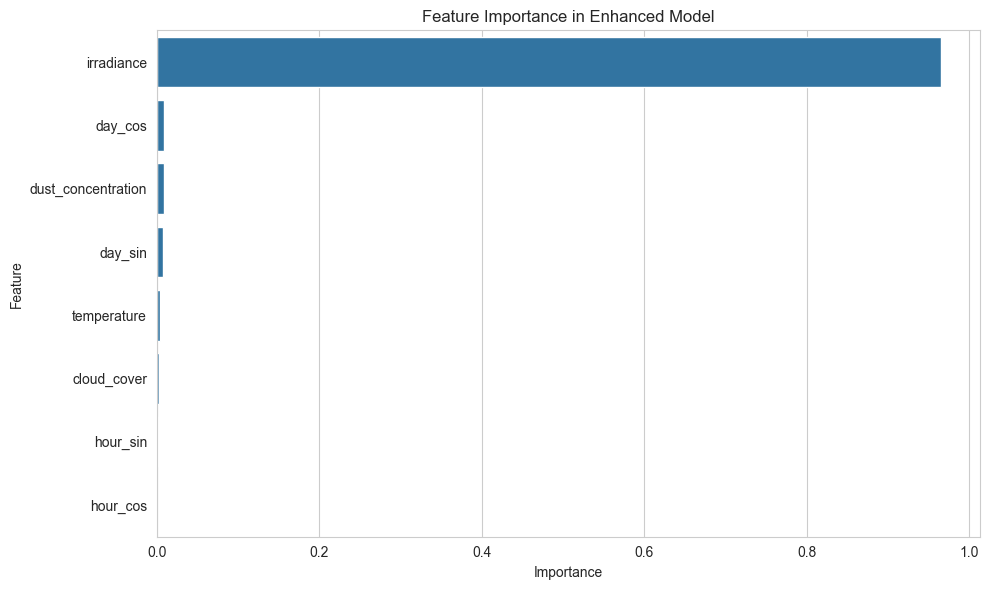

In [234]:
# Plot feature importance
plt.figure(figsize = (10, 6))
sns.barplot(x = 'Importance', y = 'Feature', data = importance_df)
plt.title('Feature Importance in Enhanced Model')
plt.tight_layout()